In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn as skl
import matplotlib.pyplot as plt
import sklearn.metrics as skmr
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from tabpfn import TabPFNClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

from IPython.display import clear_output

In [2]:
X_train = np.load("cifar10_train_X.npy")
y_train = np.load("cifar10_train_y.npy")
X_test = np.load("cifar10_test_X.npy")
y_test = np.load("cifar10_test_y.npy")

In [3]:
methods = [
    ("SVC", SVC()),
    ("LR", skl.linear_model.LogisticRegression()),
    #("kNN", KNeighborsClassifier()),
    ("XGBoost", xgb.XGBClassifier()),
    ("TabPFN", TabPFNClassifier(device='cpu', subsample_features=True)),
]
n_random = 10
n_samples_list = [30, 100, 300, 1000]
n_n_samples = len(n_samples_list)
accs = np.zeros((len(methods), n_n_samples, n_random))
f1s = np.zeros((len(methods), n_n_samples, n_random))
for nix, n_samples in enumerate(n_samples_list):
    for rix in range(n_random):
        _, cur_X_train, _, cur_y_train = train_test_split(
            X_train, y_train, test_size=n_samples / 50000, random_state=rix)
        rng = check_random_state(rix)
        for mix, (mname, method) in enumerate(methods):
            model = method
            model.fit(cur_X_train.reshape(-1, 3*32*32), cur_y_train)
            y_test_pred = model.predict(X_test.reshape(-1, 3*32*32))
            accs[mix, nix, rix] = skmr.accuracy_score(y_test, y_test_pred)
            f1s[mix, nix, rix] = skmr.f1_score(y_test, y_test_pred, average="macro")
clear_output()

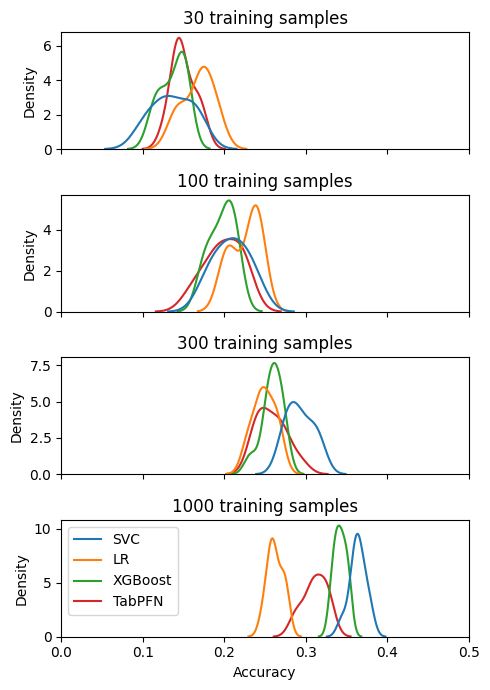

In [4]:
fig, axes = plt.subplots(figsize=(5, 7), nrows=4, sharex=True);
for nix, n_samples in enumerate(n_samples_list):
    cur_accs = accs[:, nix, :]
    accs_df = pd.DataFrame(data=cur_accs, index=[mname for mname, _ in methods]).T
    sns.kdeplot(data=accs_df, clip=(0, 1), ax=axes[nix], legend=nix == 3)
    if nix == 3:
        axes[nix].set_xlabel("Accuracy");
    axes[nix].set_title(f"{n_samples} training samples");
    axes[nix].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5]);
plt.tight_layout();
plt.savefig("/Users/calvinm/sandbox/iclr-2024/assets/cifar10-vs-samples.pdf");